# Import libraries and manage dataset

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# Code for importing dataset from Kaggle using the Kaggle API

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 321M/330M [00:03<00:00, 98.9MB/s]
100% 330M/330M [00:03<00:00, 101MB/s] 


In [ ]:
# Import all the required libraries 

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pathlib
import zipfile
import os
import PIL
import numpy as np
from keras.preprocessing import image_dataset_from_directory

In [ ]:
from zipfile import ZipFile
file_name = "face-mask-12k-images-dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
path = "/content/Face Mask Dataset"
print(path)

/content/Face Mask Dataset


In [ ]:
# Making train and validation directories

train_dir = os.path.join(path, 'Train')
validation_dir = os.path.join(path, 'Validation')

batch_size = 128
img_size = (160,160)

# Training images
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle = True,
    batch_size=batch_size,
    image_size = img_size
)

Found 10000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=batch_size,
                                                  image_size=img_size)

Found 800 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['WithMask', 'WithoutMask']


tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


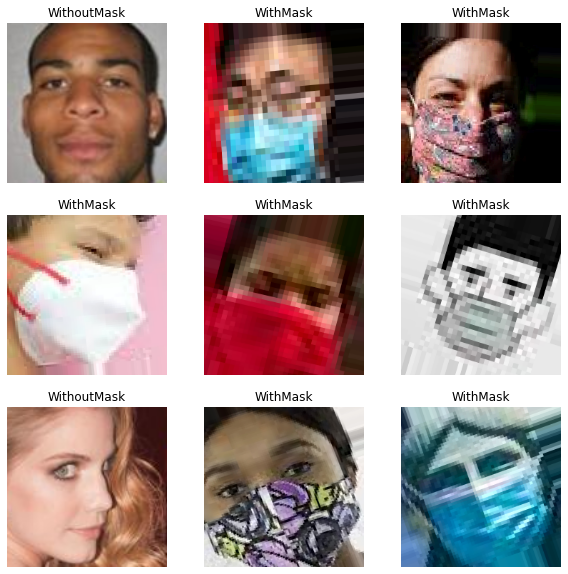

In [ ]:
# Plot some images
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax= plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    print(labels[i])
    plt.axis("off")

# Data Augmentation: Model with layers for Augmentation

In [ ]:
data_augmentation = keras.Sequential([
        keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(160,160,3)),
        keras.layers.experimental.preprocessing.RandomRotation(0.2),
        keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [ ]:
data_augmentation.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 160, 160, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 160, 160, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 160, 160, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


# Visualizing the images

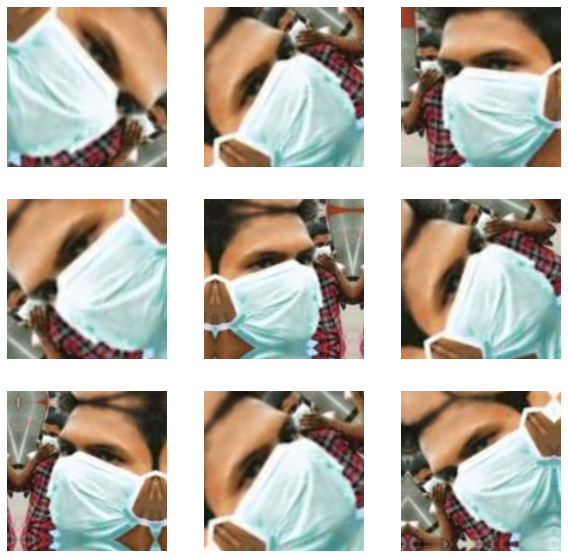

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

In [ ]:
# Preprocess the images when we need to feed them in the MobileNetV2

preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Develop base model from MobileNetV2

In [ ]:
img_shape = img_size+(3,)
base_model = keras.applications.MobileNetV2(input_shape=img_shape,
                                            include_top = False,
                                            weights = 'imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 1280)


# Feature Extraction
### Freeze the convolutional base

In [ ]:
# Currently we have to freeze all the layers
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### In the above model the non-trainable parameters are full cause we have freezed all the layers

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1,activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


## Add the classification layers above the convolutional base

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model

In [ ]:
lr = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss = keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

## Train the initial model (not the final one)

In [ ]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 3s 109ms/step - loss: 0.8273 - accuracy: 0.4420


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.45


In [ ]:
history = model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/5
79/79 [==============================] - 26s 289ms/step - loss: 0.1582 - accuracy: 0.9368 - val_loss: 0.0332 - val_accuracy: 0.9926
Epoch 2/5
79/79 [==============================] - 25s 301ms/step - loss: 0.0377 - accuracy: 0.9886 - val_loss: 0.0194 - val_accuracy: 0.9955
Epoch 3/5
79/79 [==============================] - 25s 297ms/step - loss: 0.0263 - accuracy: 0.9923 - val_loss: 0.0110 - val_accuracy: 0.9970
Epoch 4/5
79/79 [==============================] - 24s 292ms/step - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.0107 - val_accuracy: 0.9970
Epoch 5/5
79/79 [==============================] - 25s 299ms/step - loss: 0.0189 - accuracy: 0.9940 - val_loss: 0.0072 - val_accuracy: 1.0000


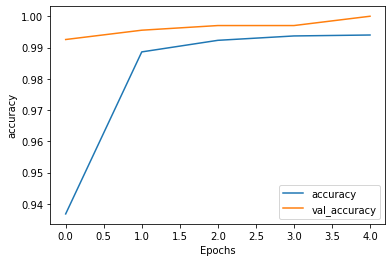

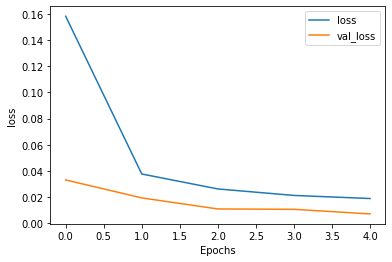

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(history, word):
  plt.plot(history.history[word])
  plt.plot(history.history['val_'+word])
  plt.xlabel('Epochs')
  plt.ylabel(word)
  plt.legend([word, 'val_'+ word])
  plt.show()

plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

## Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in base model: ", len(base_model.layers))

Number of layers in base model:  154


In [ ]:
# Fine Tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the above mentioned layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

## Compile the new model and Visulaize the model

In [ ]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = keras.optimizers.RMSprop(lr = lr/10),
              metrics = ['accuracy'])

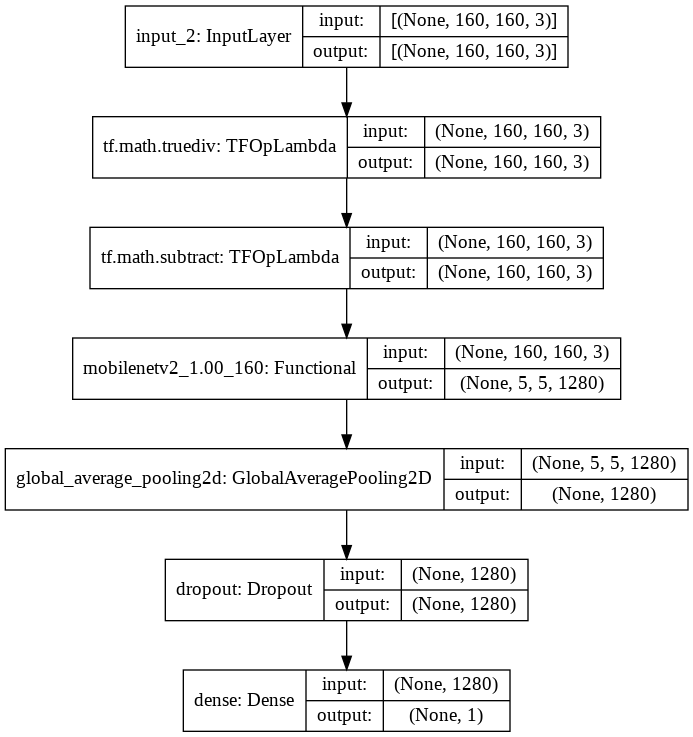

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

## New Model training

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs 

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data = validation_dataset)

Epoch 5/15
79/79 [==============================] - 29s 303ms/step - loss: 0.4449 - accuracy: 0.9415 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/15
79/79 [==============================] - 26s 310ms/step - loss: 0.0246 - accuracy: 0.9923 - val_loss: 0.0022 - val_accuracy: 0.9985
Epoch 7/15
79/79 [==============================] - 26s 312ms/step - loss: 0.0177 - accuracy: 0.9957 - val_loss: 0.0063 - val_accuracy: 0.9955
Epoch 8/15
79/79 [==============================] - 26s 311ms/step - loss: 0.0147 - accuracy: 0.9957 - val_loss: 6.2561e-04 - val_accuracy: 1.0000
Epoch 9/15
79/79 [==============================] - 26s 309ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9985
Epoch 10/15
79/79 [==============================] - 26s 315ms/step - loss: 0.0042 - accuracy: 0.9980 - val_loss: 6.3457e-06 - val_accuracy: 1.0000
Epoch 11/15
79/79 [==============================] - 26s 309ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 3.0608e-04 - val_ac

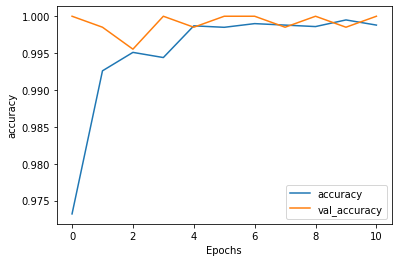

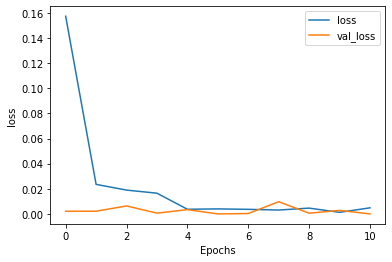

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(history, word):
  plt.plot(history.history[word])
  plt.plot(history.history['val_'+word])
  plt.xlabel('Epochs')
  plt.ylabel(word)
  plt.legend([word, 'val_'+ word])
  plt.show()

plot_graph(history_fine, 'accuracy')
plot_graph(history_fine, 'loss')

## Testing

Saving withmask1.jpeg to withmask1.jpeg


Person is wearing a mask



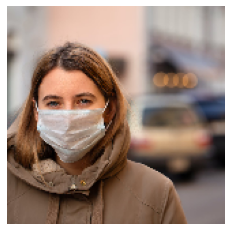

In [ ]:
# 1 - Without a mask
# 0 - With mask
# Upload and check if the model classifies the image correctly
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(160,160))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  if classes[0]>0.5:
    plt.imshow(img)
    plt.axis('off')
    print("\n\nPerson is not wearing a mask\n")
  else:
    plt.imshow(img)
    plt.axis('off')
    print("\n\nPerson is wearing a mask\n" )